In [1]:
from collections import OrderedDict
from scipy.constants import bar, atm
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
from GasNetSim.components.utils.gas_mixture.GERG2008.gerg2008 import *

In [3]:
from GasNetSim.components.utils.gas_mixture.gas_mixture import GasMixture

In [4]:
import cantera as ct

print(f"Using Cantera version: {ct.__version__}")

Using Cantera version: 2.6.0.post1


In [5]:
fuels = ["CH4", "C2H6", "C3H8", "H2", "CO"]

In [6]:
# better density calculation with gerg2008!
molar_density = [0.6484926588314163,
                 1.2228248480248802,
                 1.8085351993461924,
                 0.04065274708618872*2,
                 1.1308810162414191]
molar_density

[0.6484926588314163,
 1.2228248480248802,
 1.8085351993461924,
 0.08130549417237744,
 1.1308810162414191]

In [7]:
def heating_value(fuel):
    """Returns the LHV and HHV for the specified fuel"""
    gas.TP = 298, ct.one_atm
    gas.set_equivalence_ratio(1.0, fuel, "O2:1.0")
    h1 = gas.enthalpy_mass
    Y_fuel = gas[fuel].Y[0]

    # complete combustion products
    X_products = {
        "CO2": gas.elemental_mole_fraction("C"),
        "H2O": 0.5 * gas.elemental_mole_fraction("H"),
        "N2": 0.5 * gas.elemental_mole_fraction("N"),
    }

    gas.TPX = None, None, X_products
    Y_H2O = gas["H2O"].Y[0]
    h2 = gas.enthalpy_mass
    LHV = -(h2 - h1) / Y_fuel / 1e6
    HHV = -(h2 - h1 + (h_liquid - h_gas) * Y_H2O) / Y_fuel / 1e6
    return LHV, HHV

In [8]:
gas = ct.Solution("gri30.yaml")

In [9]:
water = ct.Water()

In [10]:
# Set liquid water state, with vapor fraction x = 0
water.TQ = 298, 0
h_liquid = water.h

In [11]:
# Set gaseous water state, with vapor fraction x = 1
water.TQ = 298, 1
h_gas = water.h

In [12]:
# cantera MJ/kg - MJ/m3
LHV_cantera_mass = []
HHV_cantera_mass = []
LHV_cantera_vol = []
HHV_cantera_vol = []

In [13]:
for i in range(len(fuels)):
    LHV, HHV = heating_value(fuels[i])
    LHV_cantera_mass.append(LHV)
    HHV_cantera_mass.append(HHV)
    LHV_cantera_vol.append(LHV*molar_density[i])
    HHV_cantera_vol.append(HHV*molar_density[i])

In [14]:
# gerg2008 kJ/kg - kJ/m3
LHV_gerg2008_mass = []
HHV_gerg2008_mass = []
LHV_gerg2008_vol = []
HHV_gerg2008_vol = []

In [15]:
gas_comp = {'methane':1, 'ethane':1, 'propane':1, 'hydrogen':1, 'carbon monoxide':1}

In [16]:
for key, value in gas_comp.items():
    gas_mixture = GasMixture(pressure=1*atm, temperature=298, composition={key:value}, method="GERG-2008")
    HHV = gas_mixture.heating_value(hhv=True, parameter='mass')
    LHV = gas_mixture.heating_value(hhv=False, parameter='mass')
    LHV_gerg2008_mass.append(LHV)
    HHV_gerg2008_mass.append(HHV)
    HHV = gas_mixture.heating_value(hhv=True, parameter='vol')
    LHV = gas_mixture.heating_value(hhv=False, parameter='vol')
    LHV_gerg2008_vol.append(LHV)
    HHV_gerg2008_vol.append(HHV)

In [17]:
LHV_gerg2008_mass = [x/1000 for x in LHV_gerg2008_mass]
LHV_gerg2008_vol = [x/1000 for x in LHV_gerg2008_vol]

In [18]:
HHV_gerg2008_mass = [x/1000 for x in HHV_gerg2008_mass]
HHV_gerg2008_vol = [x/1000 for x in HHV_gerg2008_vol]

In [19]:
LHV_close_mass = []
HHV_close_mass = []
LHV_close_vol = []
HHV_close_vol = []

In [20]:
LHV_err_mass = []
HHV_err_mass = []
LHV_err_vol = []
HHV_err_vol = []

In [21]:
for i in range(len(LHV_cantera_mass)):
    LHV_close_mass.append(math.isclose(LHV_cantera_mass[i], LHV_gerg2008_mass[i], abs_tol=0.01))
    HHV_close_mass.append(math.isclose(HHV_cantera_mass[i], HHV_gerg2008_mass[i], abs_tol=0.01))
    LHV_close_vol.append(math.isclose(LHV_cantera_vol[i], LHV_gerg2008_vol[i], abs_tol=0.01))
    HHV_close_vol.append(math.isclose(HHV_cantera_vol[i], HHV_gerg2008_vol[i], abs_tol=0.01))
    LHV_err_mass.append(abs(LHV_cantera_mass[i]-LHV_gerg2008_mass[i])/LHV_cantera_mass[i])
    HHV_err_mass.append(abs(HHV_cantera_mass[i]-HHV_gerg2008_mass[i])/HHV_cantera_mass[i])
    LHV_err_vol.append(abs(LHV_cantera_vol[i]-LHV_gerg2008_vol[i])/LHV_cantera_vol[i])
    HHV_err_vol.append(abs(HHV_cantera_vol[i]-HHV_gerg2008_vol[i])/HHV_cantera_vol[i])

<h2 style="text-align: center;"> LHV COMPARISON MJ/kg </h2>

***
| Molecule | Gerg2008 [MJ/kg] | Cantera [MJ/kg] | Relative Error [%] |
| :-: | :-: | :-: | :-: |
| CH4 | 50.028076 | 50.025488 | 0.0052 |
| C2H6| 47.512796 | 47.510518 | 0.0048 |
| C3H8| 46.353899 | 46.351730 | 0.0047 |
|  H2 | 119.960955 | 119.951950 | 0.0075 |
|  CO | 10.102758 | 10.102727 | 0.0003 |

<h2 style="text-align: center;"> HHV COMPARISON MJ/kg </h2>

***
| Molecule | Gerg2008 [MJ/kg] | Cantera [MJ/kg] | Relative Error [-] |
| :-: | :-: | :-: | :-: |
| CH4 | 55.514142 | 55.511325 | 0.0051 |
| C2H6| 51.903192 | 51.900738 | 0.0047 |
| C3H8| 50.345679 | 50.343352 | 0.0046 |
|  H2 | 141.790131 | 141.779648 | 0.0074 |
|  CO | 10.102758 | 10.102727 | 0.0003 |

<h2 style="text-align: center;"> LHV COMPARISON MJ/m3 </h2>

***
| Molecule | Gerg2008 [MJ/kg] | Cantera [MJ/kg] | Relative Error [-] |
| :-: | :-: | :-: | :-: |
| CH4 | 32.447816 | 32.441162 | 0.0205 |
| C2H6| 58.097973 | 58.097042 | 0.0016 |
| C3H8| 83.824332 | 83.828735 | 0.0053 |
|  H2 | 9.754452 | 9.752753 | 0.0174 |
|  CO | 11.425058 | 11.424982 | 0.0007 |

<h2 style="text-align: center;"> HHV COMPARISON MJ/m3 </h2>

***
| Molecule | Gerg2008 [MJ/kg] | Cantera [MJ/kg] | Relative Error [-] |
| :-: | :-: | :-: | :-: |
| CH4 | 36.006035 | 35.998687 | 0.0204 |
| C2H6| 63.466487 | 63.465512 | 0.0015 |
| C3H8| 91.042889 | 91.047723 | 0.0053 |
|  H2 | 11.529461 | 11.527464 | 0.0173 |
|  CO | 11.425058 | 11.424982 | 0.0007 |

In [22]:
# test over hydrogen and methane mixture
hhv_list_mass = []
lhv_list_mass = []
hhv_list_vol = []
lhv_list_vol = []
h_list = []

In [23]:
gas_comp = OrderedDict([('methane', 1.0), ('hydrogen', 0.0)])
h_list.append(gas_comp['hydrogen'])
gas_mixture = GasMixture(pressure=1 * atm, temperature=298, composition=gas_comp)

In [24]:
HHV = gas_mixture.heating_value(hhv=True, parameter='mass')
hhv_list_mass.append(HHV)
LHV = gas_mixture.heating_value(hhv=False, parameter='mass')
lhv_list_mass.append(LHV)
HHV = gas_mixture.heating_value(hhv=True, parameter='vol')
hhv_list_vol.append(HHV)
LHV = gas_mixture.heating_value(hhv=False, parameter='vol')
lhv_list_vol.append(LHV)

In [25]:
while gas_comp['methane'] >= 0:

    gas_comp['methane'] -= 0.01
    gas_comp['hydrogen'] += 0.01
    h_list.append(gas_comp['hydrogen'])

    gas_mixture = GasMixture(pressure=1*atm, temperature=298, composition=gas_comp)

    HHV = gas_mixture.heating_value(hhv=True, parameter='mass')
    hhv_list_mass.append(HHV)
    LHV = gas_mixture.heating_value(hhv=False, parameter='mass')
    lhv_list_mass.append(LHV)
    HHV = gas_mixture.heating_value(hhv=True, parameter='vol')
    hhv_list_vol.append(HHV)
    LHV = gas_mixture.heating_value(hhv=False, parameter='vol')
    lhv_list_vol.append(LHV)

In [26]:
h_list_perc = [i*100 for i in h_list]
hhv_list_mass = [i/1000 for i in hhv_list_mass]
lhv_list_mass = [i/1000 for i in lhv_list_mass]
hhv_list_vol = [i/1000 for i in hhv_list_vol]
lhv_list_vol = [i/1000 for i in lhv_list_vol]

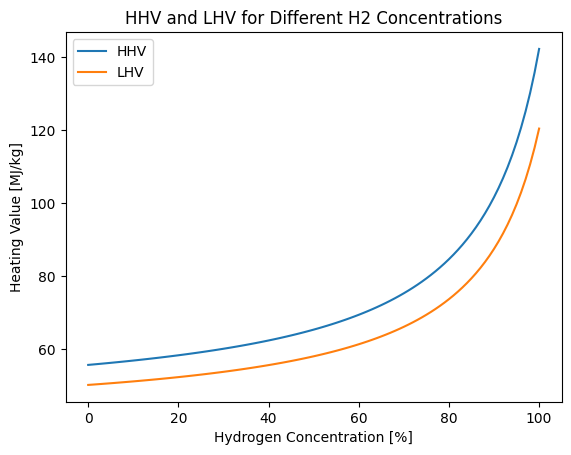

In [27]:
plt.figure()
plt.plot(h_list_perc, hhv_list_mass, label="HHV")
plt.plot(h_list_perc, lhv_list_mass, label="LHV")
plt.xlabel("Hydrogen Concentration [%]")
plt.ylabel("Heating Value [MJ/kg]")
plt.legend()
plt.title("HHV and LHV for Different H2 Concentrations")
plt.show()

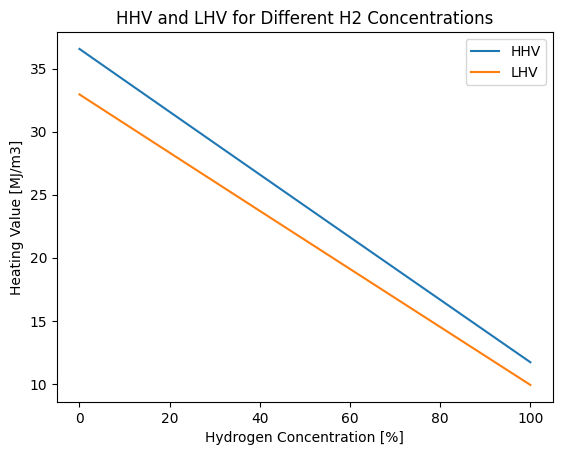

In [28]:
plt.figure()
plt.plot(h_list_perc, hhv_list_vol, label="HHV")
plt.plot(h_list_perc, lhv_list_vol, label="LHV")
plt.xlabel("Hydrogen Concentration [%]")
plt.ylabel("Heating Value [MJ/m3]")
plt.legend()
plt.title("HHV and LHV for Different H2 Concentrations")
plt.show()